In [1]:
import censusgeocode as cg
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from pyproj import CRS

from dialysis.constants import DATA_DIR

In [2]:
df = pd.read_parquet(DATA_DIR / "dialysis_facilities_geocoded.parquet")

In [3]:
df.columns

Index(['Provider Number', 'Network', 'Facility Name', 'Address Line 1',
       'Address Line 2', 'City', 'State', 'Zip', 'County', 'Phone Number',
       'Profit or Non-Profit', 'Chain Owned', 'Chain Organization',
       'ICH-CAHPS date', 'ICH-CAHPS data availability code',
       'Lower box percent of patients-nephrologists' communication and caring',
       'Middle box percent of patients-nephrologists' communication and caring',
       'Top box percent of patients-nephrologists' communication and caring',
       'Linearized score of nephrologists' communication and caring',
       'Star rating of nephrologists' communication and caring',
       'Lower box percent of patients-quality of dialysis center care and operations',
       'Middle box percent of patients-quality of dialysis center care and operations',
       'Top box percent of patients-quality of dialysis center care and operations',
       'Linearized score of quality of dialysis center care and operations',
       'Star 

<AxesSubplot: >

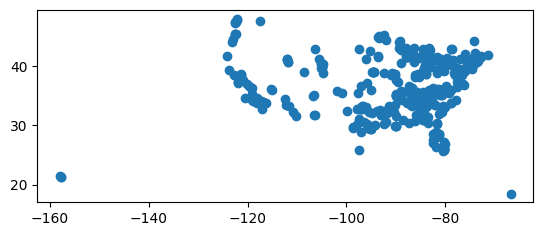

In [4]:
# Convert to geodataframe and make sure we got the right CRS
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs=CRS.from_epsg(4326))
gdf.sample(n=500).plot()

In [5]:
hrr_gdf = gpd.read_file(DATA_DIR / "us-hospital-referral-regions-hrr_1580.geojson")

<AxesSubplot: >

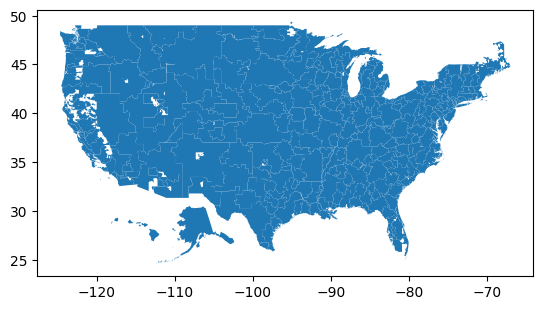

In [6]:
# Make sure we read the hrrs correctly
hrr_gdf.plot()

In [7]:
gdf = gdf.drop(columns="_merge")

In [8]:
merged_gdf = gpd.sjoin(
    gdf,
    hrr_gdf,
    how="left",
)

In [9]:
# OK, everything still appears only once
merged_gdf["Provider Number"].value_counts().value_counts()

1    7830
Name: Provider Number, dtype: int64

In [10]:
# But several places appear outside of an HRR?
merged_gdf["HRRCITY"].value_counts(dropna=False)

NaN                1731
CA- LOS ANGELES     193
GA- ATLANTA         175
TX- HOUSTON         174
TX- DALLAS          100
                   ... 
MI- PETOSKEY          2
IA- MASON CITY        2
KY- OWENSBORO         1
IA- DUBUQUE           1
MN- ST CLOUD          1
Name: HRRCITY, Length: 304, dtype: int64

<AxesSubplot: >

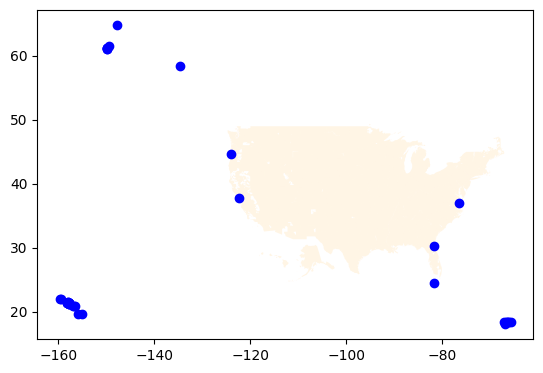

In [11]:
# OK, it looks like my hrr gdf despite being WGS84 in its CRS is being too clever
# and putting AK and HI in the wrong place.
#
# Moreover, it looks like most things outside of AK and HI are in PR. Let's check
ax = hrr_gdf.plot(alpha=0.1, color='orange')
merged_gdf[merged_gdf["HRRCITY"].isna()].plot(color="blue", ax=ax)


In [12]:
# Hmmm, seems like there's actually another problem and it's likely that the geocode
# didn't work
merged_gdf.loc[merged_gdf["HRRCITY"].isna(), "State"].value_counts().head()

TX    204
FL    115
CA    112
GA     89
PA     68
Name: State, dtype: int64

In [13]:
# OK, yes, this seems problematic
merged_gdf.loc[merged_gdf["HRRCITY"].isna() & ~merged_gdf["match"]]["State"].value_counts().head()

TX    204
FL    113
CA    111
GA     89
PA     68
Name: State, dtype: int64

In [14]:
# Hmm, yeah lots of misses
merged_gdf["match"].value_counts()

True     6147
False    1683
Name: match, dtype: int64

In [15]:
# Note that both DaVita and Fresnius match around 80% of the time, which is typical
# of the large chain organizations. So this should be corrected, e.g., with Google
# Maps or SmartyStreets in a serious analysis, but it's good enough for a quick look
pd.merge(
    merged_gdf["Chain Organization"].value_counts().head(5).to_frame(),
    merged_gdf.groupby(["Chain Organization"])["match"].mean().to_frame(),
    how="inner",
    left_index=True,
    right_index=True,
)

,Chain Organization,match
DaVita,2970,0.809428
Fresenius Medical Care,2801,0.762942
Independent,733,0.747613
US Renal Care Inc.,331,0.797583
Dialysis Clinic Inc.,262,0.820611


In [16]:
# But putting the top one into google maps does get a match
merged_gdf[~merged_gdf["match"]].head()

,Provider Number,Network,Facility Name,Address Line 1,Address Line 2,City,State,Zip,County,Phone Number,...,countyfp,tract,block,lat,lon,geometry,index_right,HRR_BDRY_I,HRRNUM,HRRCITY
49,12506,8,DAVITA DOTHAN DIALYSIS,216 GRACELAND DR.,None,DOTHAN,AL,36305,Houston,(334) 793-4077,...,None,None,None,NaN,NaN,POINT EMPTY,NaN,NaN,NaN,None
55,12509,8,FMC NORTH ALABAMA,1311 N MEMORIAL PKWY #200,None,HUNTSVILLE,AL,35801,Madison,(256) 536-8571,...,None,None,None,NaN,NaN,POINT EMPTY,NaN,NaN,NaN,None
906,12515,8,FMC OPELIKA,2609 VILLAGE PROFESSIONAL DR,STE 2,OPELIKA,AL,36801,Lee,(334) 749-5085,...,None,None,None,NaN,NaN,POINT EMPTY,NaN,NaN,NaN,None
912,12519,8,FMC SCOTTSBORO,20998 JOHN T. REID HWY,None,SCOTTSBORO,AL,35768,Jackson,(256) 259-4777,...,None,None,None,NaN,NaN,POINT EMPTY,NaN,NaN,NaN,None
924,12523,8,DAVITA PHENIX CITY DIALYSIS CENTER,4391 RIVERCHASE DRIVE,None,PHENIX CITY,AL,36867,Russell,(334) 298-0294,...,None,None,None,NaN,NaN,POINT EMPTY,NaN,NaN,NaN,None


In [17]:
# And indeed the census geocoder fails. Well, you do get what you pay for :-)

cg.address("216 GRACELAND DR.", "DOTHAN", "AL")

[]

In [18]:
# Still fails if you spell it out too
cg.address("216 GRACELAND DRIVE", "DOTHAN", "AL")

[]

In [19]:
# So this is likely to be incorrect, but we can just check the distribution of providers
# of those that acutally geocoded
focus_gdf = merged_gdf[merged_gdf["HRRCITY"].notna()]

In [20]:
# Randomize the HRRNUMs
random = np.random.default_rng(398249283)

play_gdf = focus_gdf.copy()
hrr_nums = focus_gdf["HRRNUM"].unique()
hrr_nums.sort()
answers_by_chain = []
answers_by_treatment = []
for num_trial in tqdm(range(10_000)):
    random.shuffle(hrr_nums)
    mapper = {hrr_num : i / len(hrr_nums) < 0.3 for i, hrr_num in enumerate(hrr_nums)}
    play_gdf["is_treatment"] = play_gdf["HRRNUM"].map(mapper)
    answers_by_chain.append(play_gdf.groupby("Chain Organization")["is_treatment"].mean())
    answers_by_treatment.append(play_gdf.groupby("is_treatment")["Chain Organization"].value_counts(normalize=True))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
# Pivot the answers for the top two chains
top_two_chains = list(play_gdf["Chain Organization"].value_counts().head(2).index)

chain_one_answers = []
chain_two_answers = []
treatment_one_answers = []
treatment_two_answers = []
for answer in answers_by_chain:
    chain_one_answers.append(answer.loc[top_two_chains[0]])
    chain_two_answers.append(answer.loc[top_two_chains[1]])

for answer in answers_by_treatment:
    treatment_one_answers.append((answer[False][top_two_chains[0]], answer[True][top_two_chains[0]]))
    treatment_two_answers.append((answer[False][top_two_chains[1]], answer[True][top_two_chains[1]]))


(array([   0.,    0.,    0.,    9.,  749., 4339., 4003.,  855.,   45.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

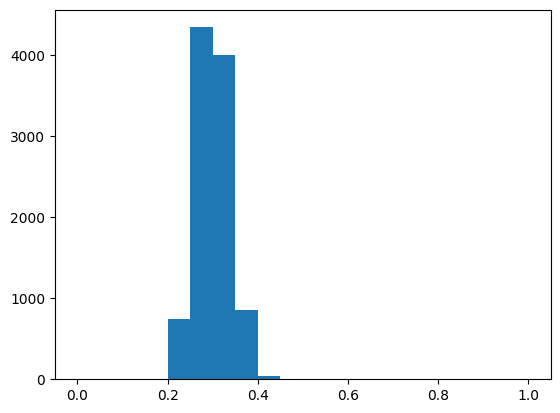

In [22]:
plt.hist(chain_one_answers, bins=np.arange(0, 1.01, 0.05))

(array([0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 4.920e+02, 4.504e+03,
        4.357e+03, 6.320e+02, 1.200e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

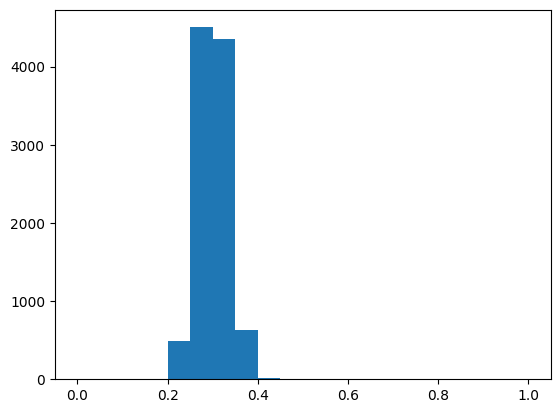

In [23]:
plt.hist(chain_two_answers, bins=np.arange(0, 1.01, 0.05))

(array([0.000e+00, 1.000e+00, 7.000e+00, 3.000e+01, 1.160e+02, 3.140e+02,
        5.850e+02, 9.120e+02, 1.322e+03, 1.651e+03, 1.693e+03, 1.344e+03,
        9.740e+02, 5.790e+02, 2.850e+02, 1.160e+02, 4.600e+01, 1.900e+01,
        4.000e+00]),
 array([-1.00000000e-01, -9.00000000e-02, -8.00000000e-02, -7.00000000e-02,
        -6.00000000e-02, -5.00000000e-02, -4.00000000e-02, -3.00000000e-02,
        -2.00000000e-02, -1.00000000e-02, -5.55111512e-17,  1.00000000e-02,
         2.00000000e-02,  3.00000000e-02,  4.00000000e-02,  5.00000000e-02,
         6.00000000e-02,  7.00000000e-02,  8.00000000e-02,  9.00000000e-02]),
 <BarContainer object of 19 artists>)

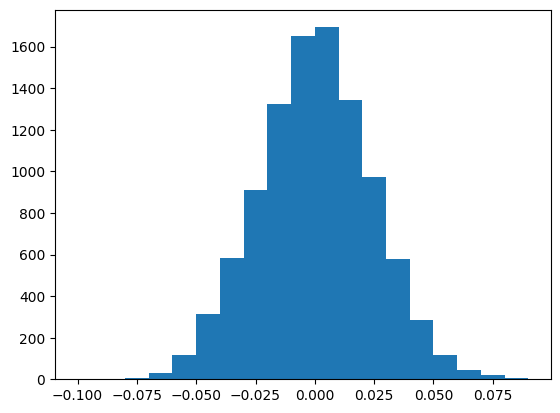

In [24]:
treatment_one_diffs = np.array([x[0] - x[1] for x in treatment_one_answers])
plt.hist(treatment_one_diffs, bins=np.arange(-0.1, 0.1, 0.01))

(array([   3.,   13.,   38.,   95.,  212.,  418.,  687.,  978., 1215.,
        1405., 1414., 1225.,  970.,  597.,  399.,  191.,   99.,   31.,
           6.]),
 array([-1.00000000e-01, -9.00000000e-02, -8.00000000e-02, -7.00000000e-02,
        -6.00000000e-02, -5.00000000e-02, -4.00000000e-02, -3.00000000e-02,
        -2.00000000e-02, -1.00000000e-02, -5.55111512e-17,  1.00000000e-02,
         2.00000000e-02,  3.00000000e-02,  4.00000000e-02,  5.00000000e-02,
         6.00000000e-02,  7.00000000e-02,  8.00000000e-02,  9.00000000e-02]),
 <BarContainer object of 19 artists>)

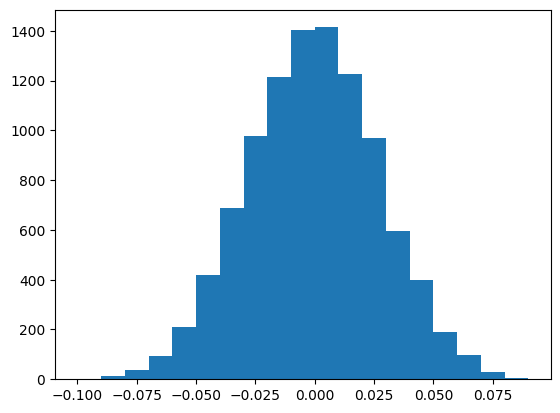

In [25]:
treatment_two_diffs = np.array([x[0] - x[1] for x in treatment_two_answers])
plt.hist(treatment_two_diffs, bins=np.arange(-0.1, 0.1, 0.01))

In [26]:
# This is the quantity we are after, but for DaVita, the top chain
# Percentages pulled from Table 2 of paper
(np.abs(treatment_one_diffs) > (0.396 - 0.362)).mean()

0.1571

In [27]:
# This is the number we are actually after. Percentages pulled from Table 2 of paper
#
# How bad is this compared to just random selection? It turns out it's *just* inside
# a 95% range, and *certainly* within a 95% range when you correct have a Bonferroni
# correction applied
(np.abs(treatment_two_diffs) > (0.412 - 0.360)).mean()

0.0604